# Model loading and LFrecon part

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from unet_layers import *
import h5py
from torch.utils.data import DataLoader
from torchvision import transforms as T
from tensorboardX import SummaryWriter
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from data_utils import FSdataset_withSAI,my_triplet_RandomCrop,my_triplet_normalize, my_triplet_CenterCrop
from visualize import show_FS,show_EPI_xu,show_EPI_yv,show_SAI
from torch.optim.lr_scheduler import MultiStepLR
from DIBR_modules import depth_rendering_pt,transform_ray_depths_pt,depth_consistency_loss_pt,image_derivs_pt,tv_loss_pt
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="0"
np.random.seed(100);
torch.manual_seed(100);
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False #Setting to True may leads to faster but undeterminsitc result.

In [2]:
bs_train = 1
bs_val = 1
lr = 3e-4

nF=7
lfsize = [372, 540, 8, 8] #H,W,v,u
disp_mult = 2
SAI_iv = 3 #index of the SAI to be selected as All in focus image, countin from 0 
SAI_iu = 3 #index of the SAI to be selected as All in focus image, countin from 0 
lam_tv = 0.01
lam_dc = 0.005
#dimensions of Lytro light fields, H,W,nv,nu. 
#Note original Lytro LF has dimension 376X541 X 14 X 14, the paper takes only first 372/540 spatial pixel and central 8 by 8 SAI
#which is being followed here

transform_train = T.Compose([my_triplet_normalize(255),my_triplet_RandomCrop(256)])
transform_val = T.Compose([my_triplet_normalize(255)]) #Note the center region is cropped out for validation, due to memory constraint

ds_train = FSdataset_withSAI(lfsize = lfsize, FSdata_path='/home/zyhuang/EVO970Plus/FS_dataset/FS_dmin_-1_dmax_0.3_nF_7.h5',LFdata_folder='/home/zyhuang/EVO970Plus/Flowers_8bit/',\
                             SAIdata_folder = '/home/zyhuang/EVO970Plus/SAI_dataset/FS_dmin_-1_dmax_0.3_nF_7_unet_FS2SAI_v3_tanh_lr_3e-4_bs_train_2_bs_val_5_full_val_loss.h5',\
                             trainorval='train',transform = transform_train)
ds_val =  FSdataset_withSAI(lfsize = lfsize, FSdata_path='/home/zyhuang/EVO970Plus/FS_dataset/FS_dmin_-1_dmax_0.3_nF_7.h5',LFdata_folder='/home/zyhuang/EVO970Plus/Flowers_8bit/',\
                            SAIdata_folder = '/home/zyhuang/EVO970Plus/SAI_dataset/FS_dmin_-1_dmax_0.3_nF_7_unet_FS2SAI_v3_tanh_lr_3e-4_bs_train_2_bs_val_5_full_val_loss.h5',\
                            trainorval='val',transform = transform_val)
log_path = 'logs/DIBR/testtime2'
writer = SummaryWriter(log_path)

train_loader=DataLoader(ds_train, batch_size=bs_train,shuffle=True, num_workers = 3,pin_memory = True)
val_loader=DataLoader(ds_val, batch_size=bs_val,shuffle=False, num_workers = 3,pin_memory = True)

In [3]:
model_folder = 'logs/DIBR/FS_dmin_-1_dmax_0.3_nF_7/concat_SAI_True_disp_mult_2/lr_3e-4_lam_tv_1e-2_lam_dc_5e-3_bs_train_1_crop_bs_val_1_crop_256'
device = torch.device("cuda")
depth_Net = depth_network_pt(nF,lfsize,disp_mult,concat_SAI = True)
refine_Net = refineNet()
depth_Net.to(device)
refine_Net.to(device)
depth_Net.load_state_dict(torch.load(model_folder + '/model_depth_Net.pth'))
refine_Net.load_state_dict(torch.load(model_folder + '/model_refine_Net.pth'))
#depth_Net.load_state_dict(torch.load('logs/DIBR/FS_dmin_-1_dmax_0.3_nF_7/concat_SAI_True_disp_mult_2/lr_3e-4_lam_tv_1e-2_lam_dc_5e-3_bs_train_1_crop_bs_val_1_crop_256' + '/model_depth_Net.pth'))
criterion = nn.L1Loss()






In [4]:
#Calculate Full loss across entire val dataset every epoch
Full_loss = 0
Full_output_loss = 0
torch.cuda.empty_cache()
for idx,data in enumerate(val_loader,0):
    depth_Net.eval()
    refine_Net.eval()
    FS,LF, est_SAI =data['FS'].to(device),data['LF'].to(device), data['SAI'].to(device)
    with torch.no_grad():
        ray_depths = depth_Net(FS,est_SAI) # B,v,u,H,W
        lf_shear_r = depth_rendering_pt(est_SAI[:,0,:,:],ray_depths.permute(0,3,4,1,2),lfsize,SAI_iu,SAI_iv) # B,H,W,v,u
        lf_shear_g = depth_rendering_pt(est_SAI[:,1,:,:],ray_depths.permute(0,3,4,1,2),lfsize,SAI_iu,SAI_iv)
        lf_shear_b = depth_rendering_pt(est_SAI[:,2,:,:],ray_depths.permute(0,3,4,1,2),lfsize,SAI_iu,SAI_iv)
        lf_shear = torch.cat([lf_shear_r.unsqueeze(5),lf_shear_g.unsqueeze(5),lf_shear_b.unsqueeze(5)],dim = 5).permute(0,5,3,4,1,2) #B,C,v,u,H,W
        lf_denoised = refine_Net(lf_shear,ray_depths) #B,C,v,u,H,W

        shear_loss = criterion(lf_shear,LF)
        tv_loss = lam_tv * tv_loss_pt(ray_depths.permute(0,3,4,1,2))
        depth_consistency_loss = lam_dc * depth_consistency_loss_pt(ray_depths.permute(0,3,4,1,2),lfsize,SAI_iu,SAI_iv)
        output_loss = criterion(lf_denoised,LF)
        loss = shear_loss + output_loss + tv_loss + depth_consistency_loss 

        print('Val visualization')
        est_SAI_grid = show_SAI(est_SAI.detach().cpu(), isshow = False) 
        FS_grid = show_FS(FS, isshow = False)
        LambertLF_SAI_grid = show_SAI(lf_shear.detach().cpu(),[(0,0),(5,5)], isshow = False)
        LambertLF_EPI_xu_grid = show_EPI_xu(lf_shear.detach().cpu(),[(100,0),(200,3)],isshow = False)
        reconLF_SAI_grid = show_SAI(lf_denoised.detach().cpu(),[(0,0),(5,5)], isshow = False)
        reconLF_EPI_xu_grid = show_EPI_xu(lf_denoised.detach().cpu(),[(100,0),(200,3)],isshow = False)
        SAI_grid = show_SAI(LF.detach().cpu(),[(0,0),(5,5)], isshow = False) 
        EPI_xu_grid = show_EPI_xu(LF.detach().cpu(),[(100,0),(200,3)], isshow = False)  

        
        B,v,u,H,W = ray_depths.shape
        writer.add_image('Val ray_depths', ray_depths.permute(0,1,3,2,4).reshape(B*v*H,u*W), idx)
        writer.add_image('Val est SAI', est_SAI_grid, idx)
        writer.add_image('Val FS', FS_grid, idx)
        writer.add_image('Val LambertLF SAI [0,0], [5,5]', LambertLF_SAI_grid, idx)
        writer.add_image('Val LambertLF EPI [100,0], [200,3]', LambertLF_EPI_xu_grid, idx)
        writer.add_image('Val reconLF SAI [0,0], [5,5]', reconLF_SAI_grid, idx)
        writer.add_image('Val reconLF EPI [100,0], [200,3]', reconLF_EPI_xu_grid, idx)
        writer.add_image('Val trueLF SAI [0,0], [5,5]', SAI_grid, idx)
        writer.add_image('Val trueLF EPI [100,0], [200,3]', EPI_xu_grid, idx) 
        
    Full_loss += loss.item()
    Full_output_loss += output_loss.item()
    print('Minibatch val_loss is:%.4f' %(loss.item()))
    print('Minibatch val_output_loss is:%.4f' %(output_loss.item()))
    if idx ==9:
        break


Full_loss = Full_loss/len(val_loader) # this assumes each batch has same size
Full_output_loss = Full_output_loss/len(val_loader)
print('Full val_loss is:%.4f' %(Full_loss))
print('Full output_loss is:%.4f' %(Full_output_loss))  
        


Val visualization
Minibatch val_loss is:0.0179
Minibatch val_output_loss is:0.0075
Val visualization
Minibatch val_loss is:0.0274
Minibatch val_output_loss is:0.0113
Val visualization
Minibatch val_loss is:0.0142
Minibatch val_output_loss is:0.0060
Val visualization
Minibatch val_loss is:0.0230
Minibatch val_output_loss is:0.0097
Val visualization
Minibatch val_loss is:0.0260
Minibatch val_output_loss is:0.0102
Val visualization
Minibatch val_loss is:0.0235
Minibatch val_output_loss is:0.0094
Val visualization
Minibatch val_loss is:0.0450
Minibatch val_output_loss is:0.0180
Val visualization
Minibatch val_loss is:0.0224
Minibatch val_output_loss is:0.0095
Val visualization
Minibatch val_loss is:0.0355
Minibatch val_output_loss is:0.0142
Val visualization
Minibatch val_loss is:0.0264
Minibatch val_output_loss is:0.0101
Full val_loss is:0.0026
Full output_loss is:0.0011


# Experimental Coding part

In [ ]:
%matplotlib inline
reconLF_SAI_grid = show_SAI(lf_denoised.detach().cpu(),[(0,0),(5,5)], isshow = True)

In [5]:
%matplotlib auto
plt.imshow(ray_depths.permute(0,1,3,2,4).reshape(B*v*H,u*W).cpu().numpy())
plt.show()

Using matplotlib backend: Qt5Agg


In [12]:
lam_dc * depth_consistency_loss_pt(ray_depths.permute(0,3,4,1,2),lfsize)

tensor(0.0005, device='cuda:0')

In [13]:
lam_dc * depth_consistency_loss_pt(ray_depth2.permute(0,3,4,1,2),lfsize)

tensor(3.8903e-05, device='cuda:0')

In [7]:
ray_depth2 = ray_depths.clone()
ray_depth2[:,:,:,:,:] = ray_depths[0,3,3,:,:]

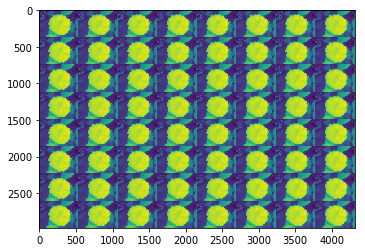

In [9]:
%matplotlib inline
plt.figure()
plt.imshow(ray_depth2.permute(0,1,3,2,4).reshape(B*v*H,u*W).cpu().numpy())
plt.show()

In [ ]:
def my_psnr(I,Iref,peakval):
    mse = ((I-Iref)**2).mean()
    return 10*np.log10(peakval**2/mse)

In [ ]:
my_psnr(reconLF[4].cpu(),LF[4].cpu(),1)

In [ ]:
my_psnr(reconLF[1][:,:-1,:-1].cpu(),LF[1][:,:-1,:-1].cpu(),1)

In [ ]:
reconLF.shape

In [ ]:
(reconLF-LF).mean()

In [ ]:
show_FS(FS[[0]].detach().cpu(), isshow = True)

In [ ]:
plt.figure()
reconSAI_grid = show_SAI(reconLF.detach().cpu(),[(0,0),(5,5)], isshow = True)
#reconEPI_xu_grid = show_EPI_xu(reconLF.detach().cpu(),[(100,0),(200,3)],isshow = True)

In [ ]:
inds = []
for i in range(8):
    for j in range(8):
        inds.append((i,j))

In [ ]:
show_FS()

In [ ]:
plt.figure()
reconSAI_grid = show_SAI(reconLF[[1]].detach().cpu(),[(0,0),(2,2),(3,3),(4,4),(5,5)], isshow = True)
#reconEPI_xu_grid = show_EPI_xu(reconLF.detach().cpu(),[(100,0),(200,3)],isshow = True)

In [ ]:
((LF- reconLF).abs().mean()).item()

In [ ]:
reconSAI_grid = show_SAI(reconLF.detach().cpu(),[(0,0),(5,5)], isshow = True)

In [ ]:
reconLF[1,0,0,0]

In [ ]:
LF[1,0,4,4]

In [ ]:
(LF[1,0,4,4]-reconLF[0,0,0,0]).abs().mean()

In [ ]:
ht,bins = np.histogram((reconLF[4]-LF[4]).abs().cpu(),bins=1000)

In [ ]:
plt.plot(bins[:30],ht[:30])

In [ ]:
bins

In [ ]:
list(net.children())[0].children(

In [ ]:
from tensorboardX import SummaryWriter
log_path = 'logs/valtest'
#writer = SummaryWriter('logs/no_crop/FS_dmin_-1_dmax_0.3_nF_7/unet_FS2LF_v2/lr_1e-3_bs_train_4_bs_val_10_pin_memory')
writer = SummaryWriter(log_path)
writer.add_image('val reconLF SAI [0,0], [5,5]', reconSAI_grid, 0)

In [ ]:
reconSAI_grid[reconSAI_grid < 0] = 1

In [ ]:
plt.imshow(reconSAI_grid.permute([1,2,0]))
plt.show()

In [ ]:

l = nn.Linear(2, 2)
net2 = nn.Sequential(l, l)
for idx, m in enumerate(net2.named_children()):
        print(idx, '->', m)

In [ ]:
net.modules

In [ ]:
import scipy.io as sio
sio.savemat('val_LF.mat',{'LF':LF.cpu().numpy()})

In [ ]:
from skimage.measure import compare_ssim as ssim

In [ ]:
ssim(LF[0].cpu().numpy().transpose([1,2,3,4,0]),reconLF[0].cpu().numpy().transpose([1,2,3,4,0]),multichannel=True)

In [ ]:
from scipy.io import loadmat

In [ ]:
result = loadmat('result.mat')

In [ ]:
ssim(result['trueLF_rgb'],result['reconLF_rgb'],multichannel=True)

In [ ]:
result.keys()